# Multilayer Perceptron and Evaluation
#### by Aviraj Sinha

## Business Case

This dataset contains statistics on streams of packets such as timeframes sent, speed, jitter, port numbers, and volume. They are categorized by the device type (thermostat, camera, doorbell) and the type of infection (benign, gafgyt, and mirai). Though not found in the wild (production environments) this dataset can be a useful microcosm of the current security landscape for IOT devices.
> Dataset source: https://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT

As the ease of setting up networks increases, more and more devices are being interconnected to ease tranmission of data, especially of sensors to gather data. However, this convenience also allows widespread malware infection of devices since new authentication protocols are still in the early stages of their development. As a result of a combination of interconnectedness and lack of security, one of the greatest threats to IOT networks are botnets. A botnet is essentially a network of computers that have been unknowingly hacked and have their computing power harnessed to attack other computers.

>Here is an article on how people are using the mirai botnet on iot networks:
>https://www.csoonline.com/article/3258748/security/the-mirai-botnet-explained-how-teen-scammers-and-cctv-cameras-almost-brought-down-the-internet.html

The model created will be used in a misuse based IDS. This differs from an anomaly based IDS in that it has not been calibrated to work with unseen threats but is very accurate in classifying previously seen ones. This type of IDS is relevant since implementations of these botnets are now opensource and are still dangerous on most systems. Another added benefit to this implemenation is that it can also classify what specific type of device has been controlled. This feature would be useful for segmenting off the infiltrated parts of the network.

This model would be deployed in a variety of business environments that require IOT for either tracking or monitoring of data in various geographic locations. The implications of having botnet on the network would mean either very heavy downtime during an attack launch and legal fees of having a botnet that attacks others. In a worst case this could bring the system to a halt and ruin the business. As a result, the accuracy of a misuse based IDS should be very accurate and quick to detect. Since there will be multiple streams of attacks that have already been enumerated, the algorithm should be able to detect about 99% of attacks as a decent standard.



In [1]:
#https://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.special import expit
import sys
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin

## Preprocessing

### Importing Data

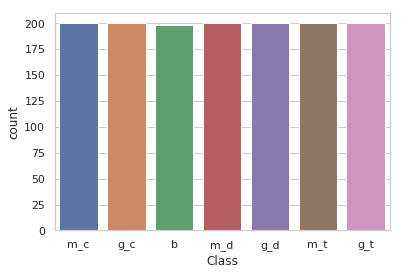

In [2]:
#creating an equal amount of data in each categoty in data fram iot traffic
b_thermostat = pd.read_csv('Ecobee_Thermostat/benign_traffic.csv')
limit = 200
b_thermostat = b_thermostat.sample(int(limit/3))
g_thermostat = pd.read_csv('Ecobee_Thermostat/gafgyt_attacks/scan.csv')
g_thermostat = g_thermostat.sample(limit)
g_thermostat.shape
m_thermostat = pd.read_csv('Ecobee_Thermostat/mirai_attacks/scan.csv')
m_thermostat = m_thermostat.sample(limit)
m_thermostat.shape

b_camera = pd.read_csv('SimpleHomeCamera/benign_traffic.csv')
b_camera = b_camera.sample(int(limit/3))
g_camera = pd.read_csv('SimpleHomeCamera/gafgyt_attacks/scan.csv')
g_camera = g_camera.sample(limit)
g_camera.shape
m_camera = pd.read_csv('SimpleHomeCamera/mirai_attacks/scan.csv')
m_camera = m_camera.sample(limit)
m_camera.shape

b_doorbell = pd.read_csv('Danmini_Doorbell/benign_traffic.csv')
b_doorbell = b_doorbell.sample(int(limit/3))
g_doorbell = pd.read_csv('Danmini_Doorbell/gafgyt_attacks/scan.csv')
g_doorbell = g_doorbell.sample(limit)
g_doorbell.shape
m_doorbell = pd.read_csv('Danmini_Doorbell/mirai_attacks/scan.csv')
m_doorbell = m_doorbell.sample(limit)
m_doorbell.shape

b_camera["Class"] = "b"
m_camera["Class"] = "m_c"
g_camera["Class"] = "g_c"

b_doorbell["Class"] = "b"
m_doorbell["Class"] = "m_d"
g_doorbell["Class"] = "g_d"

b_thermostat["Class"] = "b"
m_thermostat["Class"] = "m_t"
g_thermostat["Class"] = "g_t"

iot_traffic = []
all_dfs = [m_camera, g_camera, b_camera,
             b_doorbell, m_doorbell, g_doorbell,
             b_thermostat, m_thermostat, g_thermostat]

iot_traffic = pd.concat(all_dfs).reset_index(drop=True)
iot_traffic.head()
iot_traffic.shape
list(iot_traffic.columns)

# sns.heatmap(iot_traffic.corr())
# plt.show()


#show the equal balance of classes
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="Class", data=iot_traffic)
plt.show()

Imported equal amount for each class to avoid class imbalance.
Labels are 

`
'b': benign

'g': gafgyt_attacks

'm': mirai_attacks

'c': camera

'd': doorbell

't': thermostat
`


### Formatting Data

In [3]:
#formatting data
X = iot_traffic.drop(columns=["Class"])
y = iot_traffic["Class"]


X = SelectKBest(f_classif, k=10).fit_transform(X, y)


n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)


n_samples: 1398
n_features: 10
n_classes: 7
['b' 'g_c' 'g_d' 'g_t' 'm_c' 'm_d' 'm_t']


Took only the 10 features from the data set that have higher variance.
From viewing dimensionality and variance graph 5 dimensions capture most 90% of the varience.

## Evaluation

### Evaluation Metric

For this model recall_score is used. We want to prioritize the recall of botnet infections to be high. This is because the risk of misclassification is very unforgiving. The longer the detection takes the more the botnet spreads. The other result of viewing a false positive would be detraction from normal work but the avoidance of a botnet makes it well worth it.

An even more ideal scoring method could be made from our domain knowledge. For example, the score of classifying a botnet as the wrong type should be much better than classifying it as benign. Furthermore, misclassifications of the wrong type of device are much less important than detecting the actual presence of the botnet. This would be useful for a future implementation but for now recall score is more straightforward and already made.

### Cross Validation

The kfolds cross validation would be best to see the multiple results of the algorithm's classification success and limit the variation of a small dataset.

The stratification is not needed to even out variance from class imbalances and would take longer.
Furthermore, having more infected data would be realistic in helping increase the recall rate for this type of misuse IDS, which relies more on infected data rather than a baseline normal for anomaly detection.

This validation strategy is realistically mirrored since the ids would know these botnets exist they would be able to train ahead of time on a decent amount of previously seen data. For this dataset, I will use 5 folds because going through all parameters takes a while.

## Modeling

### Custom implementation

In [4]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

class MultilayerPerceptron(BaseEstimator):
    def __init__(self, cost="quad", layers =  2, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, shuffle=True,
                              minibatches=1, phi="sig"):
        np.random.seed(random_state)
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        self.n_hidden = n_hidden
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.layers = layers
        self.cost=cost
        self.phi = phi


    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _lu_initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ;
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.


        # reduce the final layer magnitude in order to balance the size of the gradients
        # between

        w = []

        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        w.append(W1)

        for i in range(self.layers-2):
            W = np.random.randn(self.n_hidden, self.n_hidden + 1)
            W[:,1:] = W[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
            W[:,:1] = 0 # common practice to start with zero bias
            w.append(W)

        init_bound = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        W2[:,:1] = 0
        w.append(W2)

        return np.array(w)
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
         # common practice to start with zero bias

        w = []

        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        W1[:,:1] = 0
        w.append(W1)

        for i in range(self.layers-2):
            W = np.random.randn(self.n_hidden, self.n_hidden + 1)
            W[:,1:] = W[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
            W[:,:1] = 0 # common practice to start with zero bias
            w.append(W)

        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        W2[:,:1] = 0 # common practice to start with zero bias
        w.append(W2)

        return np.array(w)


    def _phi(self,z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        if self.phi == "sig":
            return expit(z)
        elif self.phi == "lin":
            return  np.clip(z,0,1)
        elif self.phi=="silu":
            return expit(z) * np.clip(z,0,1)
        elif self.phi=="rilu":
            return np.maximum(0,z.copy())

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, W, layers):
        """Compute L2-regularization cost"""
        mean = 0
        for i in range(0, layers):
            mean += np.mean(W[i][:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(mean)

    def _cost(self,A_top,Y_enc,W):
        '''Get the objective function value'''
        if self.cost=="entr":
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_top)+(1-Y_enc)*np.log(1-A_top))))
        elif self.cost=="quad":
            cost = np.mean((Y_enc-A_top)**2)

        L2_term = self._L2_reg(self.C, W, self.layers)
        return cost + L2_term

    def _lu_feedforward(self, X, W):
        """Compute feedforward step
        """

        A, Z = np.asarray([None]*(self.layers+1)), np.asarray([None]*self.layers)
        A[0] = self._add_bias_unit(X, how='column')
        A[0] = A[0].T
        Z[0] = W[0] @ A[0]
        A[1] = self._phi(Z[0])

        for i in range(1, self.layers-1):
            A[i] = self._add_bias_unit(A[i], how='row')
            Z[i] = W[i] @ A[i]
            A[i+1] = self._phi(Z[i])

        A[self.layers-1] = self._add_bias_unit(A[self.layers-1], how='row')
        Z[self.layers-1] = W[self.layers-1] @ A[self.layers-1]
        A[self.layers] = expit(Z[self.layers-1])

        return A, Z
    
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A, Z = np.asarray([None]*(self.layers+1)), np.asarray([None]*self.layers)
        A[0] = self._add_bias_unit(X, how='column')
        A[0] = A[0].T
        Z[0] = W[0] @ A[0]
        A[1] = self._phi(Z[0])

        for i in range(1, self.layers):
            A[i] = self._add_bias_unit(A[i], how='row')
            Z[i] = W[i] @ A[i]
            A[i+1] = self._phi(Z[i])

        return A, Z
    
    def _lu_get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V = np.asarray([None]*(self.layers))

        grads = []

        # vectorized backpropagation
        if self.cost=="entr":
            V[self.layers-1] = (A[self.layers]-Y_enc)
        elif self.cost=="quad":
            V[self.layers-1] = -2*(Y_enc-A[self.layers])*A[self.layers]*(1-A[self.layers])  # last layer sensitivity

        grads.append( V[self.layers-1] @ A[self.layers-1].T) # no bias on final layer)

        # V3[Z2<=0] = 0 # can change to be relu back prop on this layer too!

        # old update: V1 = A2*(1-A2)*(W2.T @ V2)
        # the derivative of sigmoid was A2(1-A2), but now that is relu
        # so we change it to:
        for i in range(self.layers-1,0,-1):
            Z_with_bias = self._add_bias_unit(Z[i-1],how='row')
            V[i-1] = W[i].T @ V[i]
            V[i-1][Z_with_bias <=0] = 0
             # back prop the sensitivity
            V[i-1] = V[i-1][1:,:]
            grads.insert(0,  V[i-1] @ A[i-1].T) # dont back prop sensitivity of bias



        # regularize weights that are not bias terms
        for i in range(len(grads)):
            grads[i][:, 1:] += W[i][:, 1:] * self.C

        return np.array(grads)
    
    def _get_gradient(self, A, Z, Y_enc, W):
        V = np.asarray([None]*(self.layers))

        grads = []

        # vectorized backpropagation
        if self.cost=="entr":
            V[self.layers-1] = (A[self.layers]-Y_enc)
        elif self.cost=="quad":
            V[self.layers-1] = -2*(Y_enc-A[self.layers])*A[self.layers]*(1-A[self.layers])  # last layer sensitivity

        grads.append( V[self.layers-1] @ A[self.layers-1].T) # no bias on final layer)

        for i in range(self.layers-1,0,-1):

            V[i-1] = A[i]*(1-A[i])*(W[i].T @ V[i]) # back prop the sensitivity
            V[i-1] = V[i-1][1:,:]
            grads.insert(0,  V[i-1] @ A[i-1].T) # dont back prop sensitivity of bias


        # regularize weights that are not bias terms
        for i in range(len(grads)):
            grads[i][:, 1:] += W[i][:, 1:] * self.C

        return np.array(grads)


    def predict(self, X):
        """Predict class labels"""
        if self.phi =="rilu" or self.phi=="silu":
            A, Z = self._lu_feedforward(X, self.W)
        else:
            A, Z = self._feedforward(X, self.W)
        
        y_pred = np.argmax(A[self.layers], axis=0)
        return y_pred


    def fit(self, X, y):
        print_progress=False
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        if self.phi =="rilu" or self.phi=="silu":
            self.W = self._lu_initialize_weights()
        else:
            self.W = self._initialize_weights()

        delta_W_prev = []
        for i in range(len(self.W)):
            delta_W_prev.append(np.zeros(self.W[i].shape))
        delta_W_prev = np.array(delta_W_prev)
        self.cost_ = []
        self.score_ = []
        self.grad_w = []
        # get starting acc

        self.score_.append(recall_score(mapped_attack(y_data),self.predict(X_data),average="macro"))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)

                cost = self._cost(A[self.layers],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                if self.phi =="rilu" or self.phi=="silu":
                    grad = self._lu_get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                else:
                    grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)

                # momentum calculations
                delta_W = self.eta * grad
                self.W -= (delta_W + (self.alpha * delta_W_prev))
                delta_W_prev = delta_W

            curr_grad=[]
            for i in range(len(self.W)):
                curr_grad.append(np.mean(np.abs(grad[i])))
            self.grad_w.append(curr_grad)

            self.cost_.append(mini_cost)
            self.score_.append(recall_score(mapped_attack(y_data),self.predict(X_data),average="macro"))

        return self




def mapped_attack(y_test):
    mapped_attacks = { "b":0, "g_c":1, "g_d":2, "g_t":3, "m_c":4, "m_d":5, "m_t":6}
    df = pd.DataFrame({"y_t": y_test})
    df['y_t'] = df['y_t'].map(mapped_attacks)
    df = df.fillna(0)
    return df['y_t'].values

### Tune Hyper-Parameters

In [5]:
#grid search
import warnings
warnings.filterwarnings('ignore')

def score_func(y, y_pred, **kwargs):
    return recall_score(mapped_attack(y),y_pred, average="macro")

my_scorer = make_scorer(score_func)

vals = { 'n_hidden':10,
         'C':1e-2, 'epochs':200, 'eta':0.001,
         'alpha':0.001, 'decrease_const':1e-6, 'minibatches':10,
         'shuffle':True,'random_state':1, 'layers':4, 'cost':'entr', 'phi': 'lin'}

pipe_nn = Pipeline([('scaling', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('clf', MultilayerPerceptron(**vals))])
param_grid = {
    'clf__C':[1e-2],
    'clf__cost':["entr","quad"],
    'clf__layers':[2,3,4],
    'clf__phi':["lin", "sig","rilu","silu"],
    'clf__epochs':[400]
    }

cv = KFold(n_splits=5)

print(pipe_nn.get_params().keys())

gs = GridSearchCV(pipe_nn, param_grid,scoring=my_scorer, cv=cv, verbose=1)

best_model = gs.fit(X_train, y_train.values)

dict_keys(['memory', 'steps', 'scaling', 'pca', 'clf', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'clf__C', 'clf__alpha', 'clf__cost', 'clf__decrease_const', 'clf__epochs', 'clf__eta', 'clf__layers', 'clf__minibatches', 'clf__n_hidden', 'clf__phi', 'clf__random_state', 'clf__shuffle'])
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.1min finished


Best Num Layers: 4
Best Phi: rilu
Best Cost: entr
Best Recall accuracy from the combination:  0.6289356000180317
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        36
          1       0.39      0.64      0.49        42
          2       0.40      0.05      0.09        41
          3       0.38      0.47      0.42        38
          4       0.76      0.40      0.52        48
          5       1.00      0.97      0.99        37
          6       0.53      0.87      0.66        38

avg / total       0.63      0.61      0.58       280



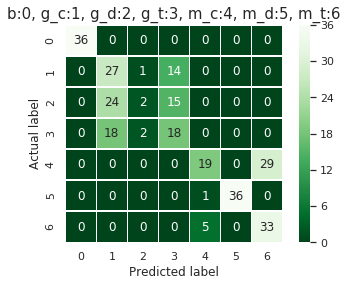

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__cost,param_clf__epochs,param_clf__layers,param_clf__phi,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,6.602226,0.100623,0.003878,0.000299,0.01,entr,400,4,rilu,"{'clf__C': 0.01, 'clf__cost': 'entr', 'clf__ep...",...,0.599412,0.018036,1,0.608863,0.594905,0.618632,0.626408,0.60531,0.610824,0.010876


In [6]:
import warnings
warnings.filterwarnings('ignore')
gs_results = pd.DataFrame(gs.cv_results_)

print('Best Num Layers:', best_model.best_estimator_.get_params()["clf__layers"])
print('Best Phi:', best_model.best_estimator_.get_params()["clf__phi"])
print('Best Cost:', best_model.best_estimator_.get_params()["clf__cost"])

print('Best Recall accuracy from the combination: ',recall_score(mapped_attack(y_test), best_model.predict(X_test), average="macro"))
print(classification_report(mapped_attack(y_test), best_model.predict(X_test)))

cm = metrics.confusion_matrix(mapped_attack(y_test), best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'b:0, g_c:1, g_d:2, g_t:3, m_c:4, m_d:5, m_t:6'
plt.title(all_sample_title, size = 15);
plt.show()


gs_results[gs_results['rank_test_score']==1].head()

By looking at the classification report we can see the prioritization of the recall score as the highest value. As a result of the high recall score there are very low false negatives. Despite the low number, it can be seen that there are only a few threats falsely classified as benign. 

The best model, its parameters, and confusion matrix are shown above.

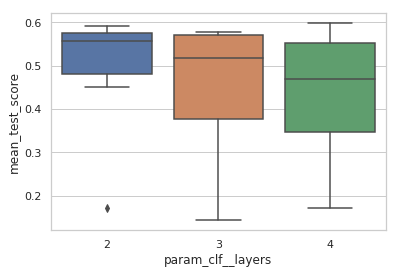

In [7]:
sns.boxplot(x='param_clf__layers', y='mean_test_score', data=gs_results).set_title('')
plt.show()

At first, it seems my implementation seems to be getting slightly worse with more layers. However, the exception comes from various combinations of parameters(using Relu and Silu) that makes multiple layers a viable option. Thus making 4 layers the best.

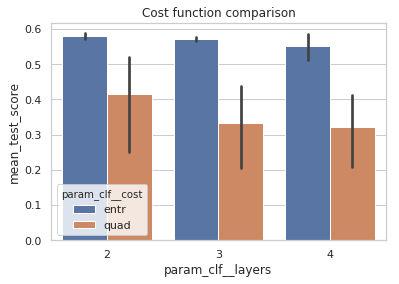

In [8]:
sns.barplot(x='param_clf__layers', y='mean_test_score',hue='param_clf__cost', data=gs_results).set_title('Cost function comparison')
plt.show()

The cross entropy cost function performs much better. In a non-convex problem MSE leads to finding a higher minima. Using cross entropy finds a more optimal minima.

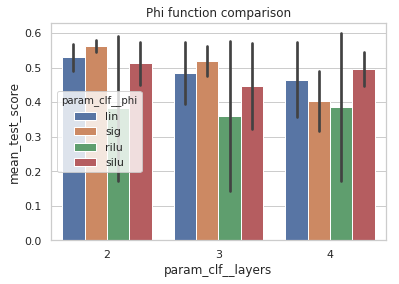

In [9]:
sns.barplot(x='param_clf__layers', y='mean_test_score', hue='param_clf__phi',data=gs_results).set_title('Phi function comparison')
plt.show()

The fact that linear activation does better than the sigmoid may lead to the idea that the data is more linearly separable. Rilu and Silu stay consistent with greater layers and eventually pass linear and sigmoid.

### Gradient magnitudes

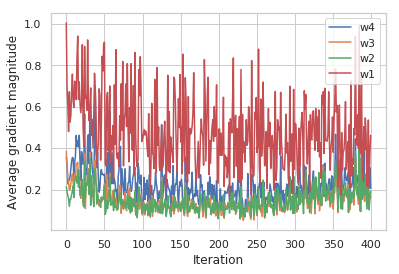

In [15]:
vals = { 'n_hidden':10,
         'C':1e-2, 'epochs':400, 'eta':0.001,
         'alpha':0.001, 'decrease_const':1e-6, 'minibatches':10,
         'shuffle':True,'random_state':1, 'layers':4, 'cost':'entr', 'phi': 'rilu'}

pipe_nn = Pipeline([('scaling', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('clf', MultilayerPerceptron(**vals))])

pipe_nn.fit(X_train, y_train.values)
y_hat = pipe_nn.predict(X_test)


grads = np.asarray(pipe_nn.named_steps['clf'].grad_w)

ax = plt.subplot(1,1,1)

for i in range(len(grads[0])):
    plt.plot(np.abs(grads[:,i]), label='w'+str(len(grads[0])-i))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The fourth gradient becomes a much greater values which means future drop out techniques may be necessary.

In [16]:
iot_traffic.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,58.879794,60.034019,4.853322e-01,74.964496,60.075998,1.087269e+00,191.371243,60.089066,1.287576,1673.632340,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,m_c
1,7.923630,60.000012,1.747777e-04,22.797807,60.000493,7.417264e-03,142.046242,60.012671,0.232355,1576.620182,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,m_c
2,88.939892,60.273807,5.500714e+00,108.779370,60.372483,7.348909e+00,225.391786,60.327764,6.652286,1291.890667,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,m_c
3,91.188866,60.000000,6.821210e-12,108.796025,60.000000,2.467987e-07,225.005867,60.000507,0.007093,1951.757661,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,m_c
4,37.045840,60.000000,1.290711e-05,51.487752,60.000102,2.844749e-03,166.140931,60.011071,0.307618,1933.376245,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,m_c
